In [32]:
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(dplyr)
library(ggplot2)
library(broom)
library(digest)

## Methods and Results
## ANOVA Test for three different rating groups
After careful analysis and discussion, we decided to apply ANOVA test first instead of multiple pair-wise tests in order to reduce the overlapping and error that is caused by multiple random selections. 
<br>
Our null hypothesis here is :
The volatile acidity level (g/dm^3) in 5-ratings group, 6-ratings group, and 7-ratings group is the same.
<br>
Our alternative hypothesis here is:
There is at least one group among the three groups whose volatile acidity level is different from others'.
<br>
We choose 0.05 as our significant(alpha) value.
<br>
Below is the code and the ANOVA table.

In [33]:
## filter and achieve the specific 3 rating groups data
wine_data_filtered <- read.csv("https://raw.githubusercontent.com/sonatuna/Group_25_Project/main/winequality-red.csv", sep = ";") |>
    mutate(quality = as.factor(quality)) |>
    filter(quality %in% c('5','6','7'))
## perform ANOVA test
anova_result <- aov( volatile.acidity ~ quality, data = wine_data_filtered)
## diplay the ANOVA table
summary(anova_result)

              Df Sum Sq Mean Sq F value Pr(>F)    
quality        2   5.22  2.6097     101 <2e-16 ***
Residuals   1515  39.15  0.0258                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## Df (Degrees of Freedom):
    * quality: This has 5 degrees of freedom. Since we have 3 quality rating groups, the degrees of freedom is 3-1 = 2.
    * Residuals: The residual degrees of freedom is 1515. This is calculated as the total number of observations minus the number of groups.
## Sum Sq (Sum of Squares):
    * quality: The variation that can be explained by differences between the quality groups is 5.22.
    * Residuals: The variation that cannot be explained by the quality groups and is due to individual differences or errors is 39.15.
## Mean Sq (Mean Squares):
    * quality: This is the explained variance (5.22) divided by its degrees of freedom (2), which equals 2.6097.
    * Residuals: This is the unexplained variance (39.01) divided by its degrees of freedom (1515), which equals 0.0258.
## F value:
    * The computed F-value is 101. It represents the ratio of explained variance to unexplained variance. A high F-value indicates that the group means are not all equal. Usually if the ratio is equal to one, it indicates that the variance can be fully explained by random selection error.
* 		Pr(>F):
    * This is the p-value associated with the F-statistic, and it's less than 2e-16 (essentially 0), which is much less than 0.05 (the alpha level). This means that the result is statistically significant at the 0.05 level (or even at much stricter levels like 0.01 or 0.001).
## Signif. codes:
    * The asterisks (*** in this case) indicate the level of significance. Three asterisks denote a very significant p-value (p < 0.001).
    * 

## Conclusion:
<br>
The ANOVA test indicates a significant difference in volatile acidity across the different quality ratings of wine. Given the extremely low p-value, we can reject the null hypothesis. This is strong evidence to suggest that at least one quality rating group have different mean volatile acidity level compared with others.

## Multiple pairwise tests
Based on the conclusion that we get from the ANOVA test above, our next step is to perform multiple pair-wise tests to determine which group's acidity level is different from the others'. In total, we are going to perform pairwise tests three times specifically in this order: 5-rating group VS 6-rating group; 6-rating group VS 7-rating group; 5-rating group VS 7-rating group.
<br>
We will explain the first test in details and make brief summary for the rest two tests since the process is higily repretitive and almost the same.

## 5-rating group VS 6-rating group
We want to compare 5-rating group with 6-rating group to see if there is a statiscally significant difference between these two groups about the level of volatile acidity.
<br>
Our null hypothesis is: The level of volatile acidity between these two groups are the same.
<br>
Our alternative hypothesis is: The level of volatile acidity between these two groups are different.
<br>
Siginificance level: 0.05
<br>
First, we get the observed difference in means.

In [34]:
obs_diff_in_means <- wine_data_filtered |>
    filter(quality %in% c('5', '6')) |>
    specify(formula = volatile.acidity ~ quality) |>
    calculate(stat = "diff in means", order = c("5", "6"))
obs_diff_in_means

Dropping unused factor levels c("3", "4", "7", "8") from the supplied explanatory variable 'quality'.



stat
<dbl>
0.07955679


Then, using permutation, we generate a null model(distribution) assuming that our null hypothesis is true. To make our analysis reproducible, we set a seed here (also for the rest two tests).

In [35]:
set.seed(2023)
null_model_acidity <- 
    wine_data_filtered|>
    filter(quality %in% c('5', '6')) |>
   specify(formula = volatile.acidity ~ quality) |>
   hypothesize(null = "independence") %>% 
   generate(reps = 5000, type = "permute") %>% 
   calculate(stat="diff in means", order = c("5", "6"))
head(null_model_acidity)

Dropping unused factor levels c("3", "4", "7", "8") from the supplied explanatory variable 'quality'.



replicate,stat
<int>,<dbl>
1,-0.006007991
2,0.004131671
3,-0.009757237
4,0.001945875
5,-0.007222322
6,-0.001120310


We visualized the null distribution and the observed difference in means to help our audience to gain a better understadning of our analysis result.

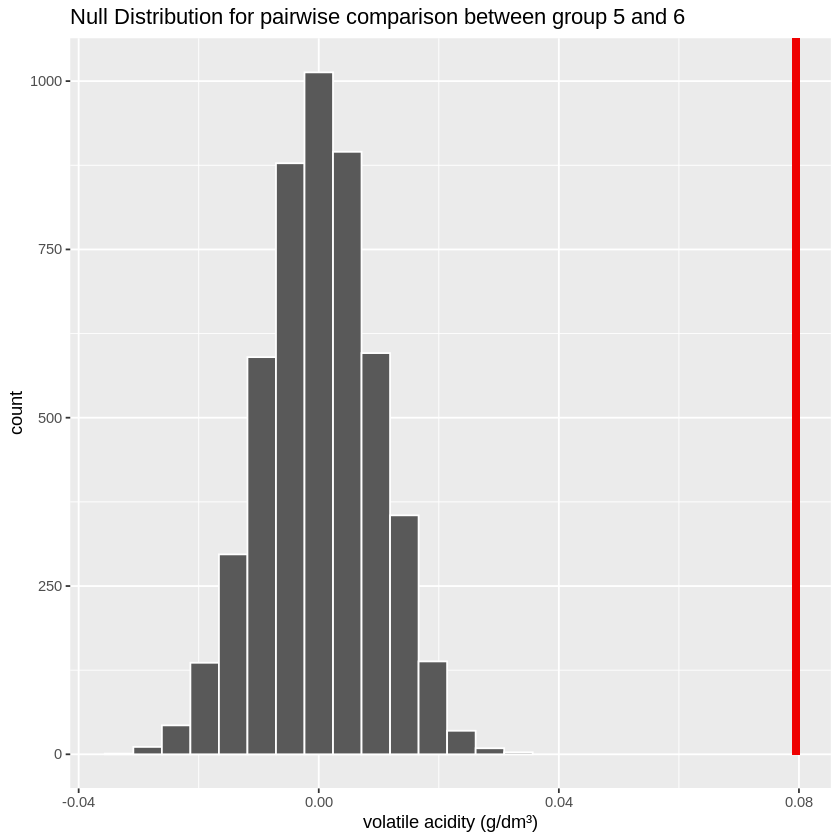

In [36]:
acidity_result_plot <- 
   null_model_acidity %>%
   visualize() + 
   shade_p_value(obs_stat = obs_diff_in_means, direction = "both") +
   xlab('volatile acidity (g/dm³)') +
    ggtitle("Null Distribution for pairwise comparison between group 5 and 6")

acidity_result_plot

The histogram is the null distribution generated by permutation and the rad vertical line indicates the observed difference in means(of the rating groups). Therefore, we may suspect that it is very unlikely to get the observed difference in means assuming that the null hypothesis is true. To prove our suspection, we need to get the p-value and compare it with our significan level.

In [37]:
p_value <- null_model_acidity |>
   get_p_value(obs_stat = obs_diff_in_means, direction = "both")
p_value

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


## P-Correction
Since we are more likely to commit a Type I error as we will test three hypotheses in total. We want to use the Bonferroni adjustment to reduce the likelihood of committing a Type I error. Specifically, we want to multiply our p-value by 3 since we will conduct three pairwise tests.

In [38]:
p_value_adjusted <- p_value * 3
p_value_adjusted

p_value
<dbl>
0


It is obvious that the p-value is sigificantly smaller than our siginicance level (0.05). Hence, we reject the null hypothesis and conclude that there is a statiscally siginificant difference between the means of 5-rating group and 6-rating group.
## Two Sample t-test

In [39]:
first_t_test <- 
    tidy(t.test(wine_data_filtered |> filter(quality == "5") |> pull(volatile.acidity),
           wine_data_filtered |> filter(quality == "6") |> pull(volatile.acidity)))
first_t_test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.07955679,0.5770411,0.4974843,8.867539,2.384872e-18,1314.712,0.0619564,0.09715718,Welch Two Sample t-test,two.sided


We also performed a two sample t-test to make sure that our conclusion is robust and accurate since the p-value we got previously is extremely small.

## The rest two Pairwise tests: 6-rating group vs 7-rating group; 5-rating group vs 7-rating group
We follow the same procedure fot these two tests.
<br>
Our null hypothesis is: The level of volatile acidity between 6-rating group and 7-rating group are the same;
<br>
The level of volatile acidity between 5-rating group and 7-rating group are the same.
<br>
Our alternative hypothesis is: The level of volatile acidity between 6-rating group and 7-rating group are different;
<br>
The level of volatile acidity between 5-rating group and 7-rating group are different.
<br>
Siginificance level: 0.05


Dropping unused factor levels c("3", "4", "5", "8") from the supplied explanatory variable 'quality'.



stat
<dbl>
0.09356473


Dropping unused factor levels c("3", "4", "5", "8") from the supplied explanatory variable 'quality'.



replicate,stat
<int>,<dbl>
1,-0.014288960
2,0.006081938
3,0.012147060
4,0.012081135
5,0.018508845
6,0.009015611


Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


p_value
<dbl>
0


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.09356473,0.4974843,0.4039196,7.727874,1.08632e-13,362.2767,0.06975505,0.1173744,Welch Two Sample t-test,two.sided


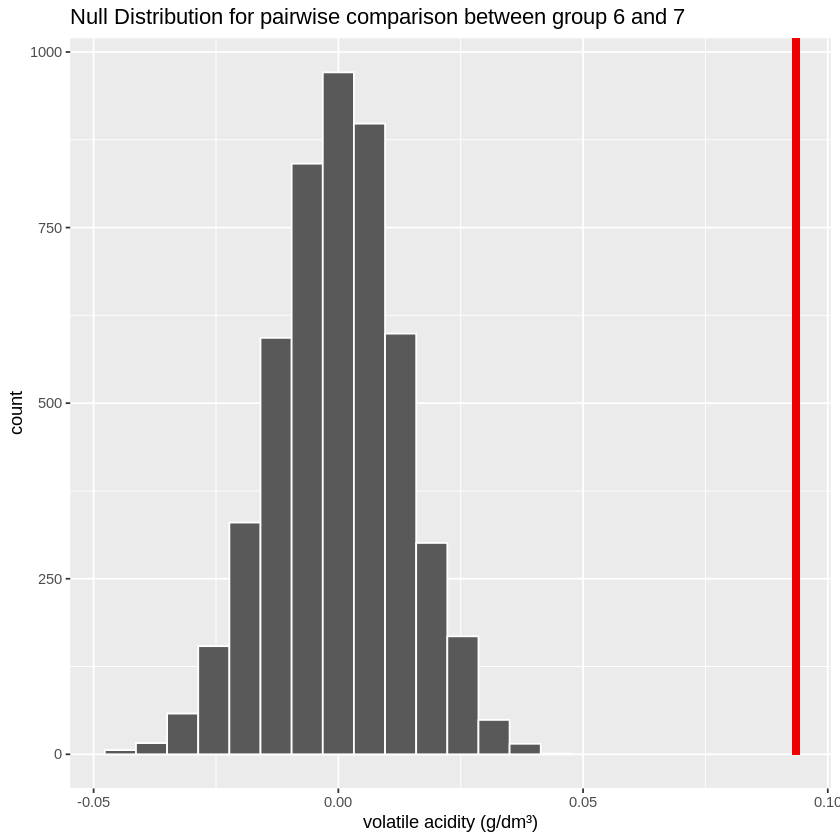

In [40]:
## 6-rating group vs 7-rating group
set.seed(2023)
obs_diff_in_means_2 <- wine_data_filtered |>
    filter(quality %in% c('6', '7')) |>
    specify(formula = volatile.acidity ~ quality) |>
    calculate(stat = "diff in means", order = c("6", "7"))
obs_diff_in_means_2
null_model_acidity_2 <- 
    wine_data_filtered|>
    filter(quality %in% c('6', '7')) |>
   specify(formula = volatile.acidity ~ quality) |>
   hypothesize(null = "independence") %>% 
   generate(reps = 5000, type = "permute") %>% 
   calculate(stat="diff in means", order = c("6", "7"))
head(null_model_acidity_2)
acidity_result_plot_2 <- 
   null_model_acidity_2 %>%
   visualize() + 
   shade_p_value(obs_stat = obs_diff_in_means_2, direction = "both") +
   xlab('volatile acidity (g/dm³)') +
    ggtitle("Null Distribution for pairwise comparison between group 6 and 7")

acidity_result_plot_2
p_value_2 <- null_model_acidity_2 |>
   get_p_value(obs_stat = obs_diff_in_means_2, direction = "both")
p_value_2
p_value_adjusted_2 <- p_value_2 * 3
p_value_adjusted_2
second_t_test <- 
    tidy(t.test(wine_data_filtered |> filter(quality == "6") |> pull(volatile.acidity),
           wine_data_filtered |> filter(quality == "7") |> pull(volatile.acidity)))
second_t_test

Dropping unused factor levels c("3", "4", "6", "8") from the supplied explanatory variable 'quality'.



stat
<dbl>
0.1731215


Dropping unused factor levels c("3", "4", "6", "8") from the supplied explanatory variable 'quality'.



replicate,stat
<int>,<dbl>
1,0.0242892510
2,0.0007501162
3,0.0187697297
4,0.0165294534
5,0.0205879249
6,-0.0009706757


Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


p_value
<dbl>
0


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.1731215,0.5770411,0.4039196,14.33441,3.445569e-37,360.2057,0.1493706,0.1968725,Welch Two Sample t-test,two.sided


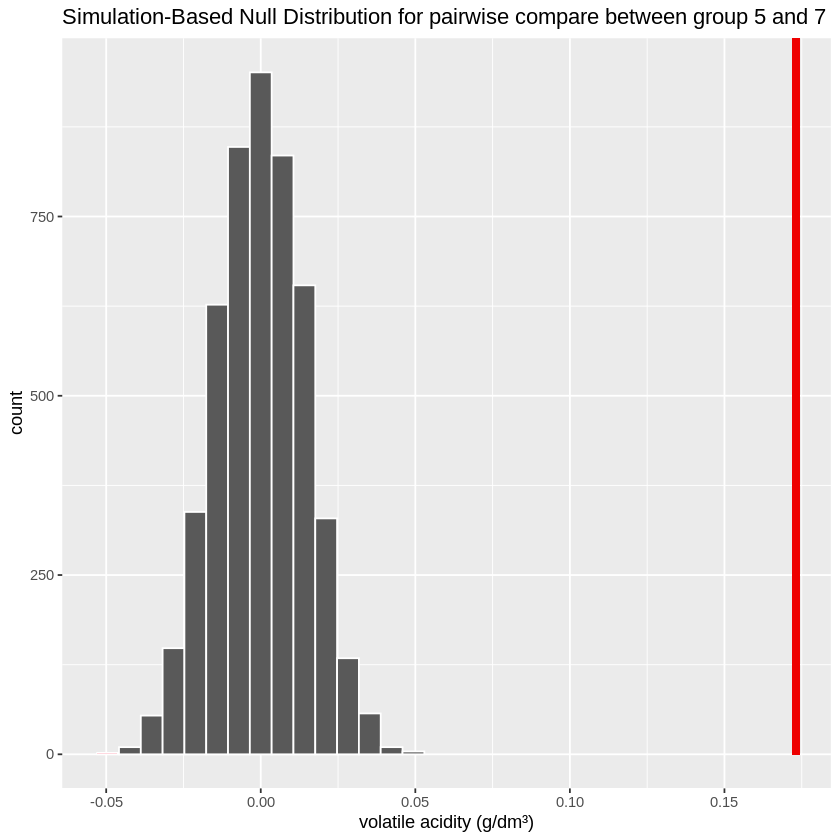

In [41]:
set.seed(2023)
obs_diff_in_means_3 <- wine_data_filtered |>
    filter(quality %in% c('5', '7')) |>
    specify(formula = volatile.acidity ~ quality) |>
    calculate(stat = "diff in means", order = c("5", "7"))
obs_diff_in_means_3
null_model_acidity_3 <- 
    wine_data_filtered|>
    filter(quality %in% c('5', '7')) |>
   specify(formula = volatile.acidity ~ quality) |>
   hypothesize(null = "independence") %>% 
   generate(reps = 5000, type = "permute") %>% 
   calculate(stat="diff in means", order = c("5", "7"))
head(null_model_acidity_3)
acidity_result_plot_3 <- 
   null_model_acidity_3 %>%
   visualize() + 
   shade_p_value(obs_stat = obs_diff_in_means_3, direction = "both") +
   xlab('volatile acidity (g/dm³)') +
    ggtitle("Simulation-Based Null Distribution for pairwise compare between group 5 and 7")

acidity_result_plot_3
p_value_3 <- null_model_acidity_3 |>
   get_p_value(obs_stat = obs_diff_in_means_3, direction = "both")
p_value_3
p_value_adjusted_3 <- p_value_3 * 3
p_value_adjusted_3
third_t_test <- 
    tidy(t.test(wine_data_filtered |> filter(quality == "5") |> pull(volatile.acidity),
           wine_data_filtered |> filter(quality == "7") |> pull(volatile.acidity)))
third_t_test

Both tests' plots indicate that observed difference in means is very unlikely to obtain and the p-values that we get from bootstrap and two sample t-test are all approaching zero. We can conclude that 6-rating group's acidity level is different from 7-rating group's acidity level, and 5-rating group's acidity level is different from 7-rating group's acidity level too.

## Final Conclusion for test results
We have strong evidences indicating that all of the three groups' acidity level is statiscally and significantly different from each other. As we take a further look at the three plots and test results provided by the t-tests above, we suspect that among the three different rating groups, the 5-rating group have the highest volatile acidity level while the 6-rating group have the smallest volatile acidity level. That being said, this is a step further from our test conclusion (different rating groups have different volatile acidity level) so that we only have a guess here. We used both bootstrap and asymptotic approaches in our methods to make sure that our results are precise. Having said that, we believe that the bootstrap approach is a better fit in our case as our sample size for different rating groups varies a lot and the 7-rating group can be a small one compared to the others. Bootstrap may show a better perfromance for small sample sizes and non-standard dsitributions and do not rely on strong assumptions about the data such as assuming the data follows a t-distribution.